In [1]:
import pandas as pd
import requests
import lxml.html
import numpy as np
import re
from kiwipiepy import Kiwi
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import time
import urllib
import matplotlib.pyplot as plt
import string
import re

from sklearn.decomposition import TruncatedSVD
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim_models

In [2]:
lotte_blog = pd.read_csv('naver_blog_롯데멤버스.csv')
lotte_cafe = pd.read_csv('naver_cafe_롯데멤버스.csv')

* [Lotte](#Lotte)
    + [title](#title)
    + [context](#context)
    + [title_context](#title_context)  
    + [year별_wordcloud](#year별_wordcloud)

# Lotte

In [3]:
lotte = pd.concat([ lotte_blog, lotte_cafe ] ).reset_index(drop = True ) ; lotte.head()

,url,type,title,date,context
0,https://blog.naver.com/rusiper1000/222665128997,naver blog,"GPEX(지펙스), 롯데멤버스 대표 영입과 MOU체결! 롯데코인?",2022. 3. 7. 17:00,"1. 지펙스(GPEX) 프로젝트\n© geralt, 출처 Pixabay\n우리는 다..."
1,https://blog.naver.com/scoolab/222795202570,naver blog,롯데멤버스 캐릭터 소형피규어 제작기,2022. 6. 30. 18:04,안녕하세요\n제작팀 입니다\n오늘은\n소형피규어 제작기를 포스팅 할 예정인데요!\n...
2,https://blog.naver.com/3dfab/222752192127,naver blog,[ 캐릭터 피규어 ] 엘포인트 엘페이 롯데멤버스 캐릭터 엘피,2022. 5. 30. 13:37,롯데멤버스 캐릭터\n엘포인트와 엘페이를 뜻하는 엘피\n캐릭터 피규어 샘플제작 전문업...
3,https://blog.naver.com/heianjung/222747317524,naver blog,"[IT취업/AI분야] 롯데멤버스 2022 신입 AI/ML 직무 채용 - 서류, 인적...",2022. 5. 27. 8:45,2022년 상반기 AI분야 취업을\n처음 본격적으로 도전하면서 경험한\n기업 별 공...
4,https://blog.naver.com/adiori/222666253209,naver blog,롯데 멤버스 MOU 협업 맺고 날개단 GPX토큰,2022. 3. 7. 16:56,롯데 멤버스 MOU 협업 맺고 날개단 GPX토큰\n개인적으로 어떠한 투자이든 그 투...


In [4]:
# 중복값 처리 
lotte.drop_duplicates(inplace = True )

# 결측값 처리
lotte.fillna("no_context", inplace = True)
lotte = lotte[lotte["context"] != "no_context"].reset_index(drop = True)

# 특수문자 제거
lotte["context"] = lotte["context"].apply(lambda x: x.replace("\n", " ")).apply(lambda x:re.sub(r'[^\w\s]', '', x))

# 제목 + 내용
lotte['title_context'] = lotte['title'] + ' '  + lotte['context']

In [5]:
stop_word = pd.read_csv("korean_stopwords.txt")
stop_word = stop_word.T.reset_index(drop=False).T.reset_index(drop = True)
stop_word.columns = ["token"]

In [6]:
def extract_noun(text):
    result = kiwi.analyze(text)
    stop_words = list(stop_word["token"])
    for token , pos , _ , _ in result[0][0]:
        if pos[0] in "NVI":
            if token not in stop_words:
                    if len(token) > 1:
                        yield token

## title

In [7]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(lotte["title"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


In [8]:
lotte_tf = word_count.sort_values("빈도",ascending = False)
lotte_tf = lotte_tf[lotte_tf.빈도 >= 10]
lotte_tf.head(10)

,단어,빈도,빈도가중치
614,롯데,1088,200.208293
621,롯데멤버스,902,160.033206
755,멤버,654,156.432273
1822,이벤트,398,96.333634
2563,포인트,295,79.630711
424,다이어리,289,129.646527
922,버스,253,72.900545
2176,채용,211,51.289734
2269,카드,190,65.370085
450,당첨,144,55.801427


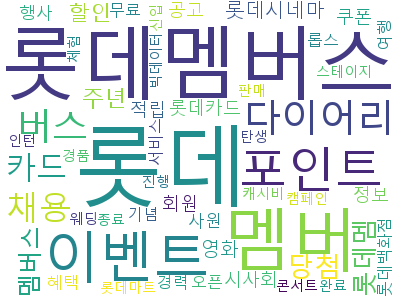

In [9]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

### LSA

In [10]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,
                  random_state=0)
svd.fit(tdm)
len(svd.components_)

print(np.shape(svd.components_))

terms = cv.get_feature_names()

def get_topics(components, feature_names, n=5) : 
    for idx, topic in enumerate(components) : # 각 토픽에 대한 주요 단어 n개 출력 
        print('Topic %d:' %(idx+1), [(feature_names[i], topic[i].round(5)) 
                    for i in topic.argsort()[:-n - 1 : -1]])
get_topics(svd.components_, terms)

(20, 2833)
Topic 1: [('롯데', 0.72028), ('멤버', 0.49757), ('이벤트', 0.31554), ('롯데멤버스', 0.22608), ('다이어리', 0.14368)]
Topic 2: [('롯데멤버스', 0.8698), ('이벤트', 0.25314), ('포인트', 0.0933), ('주년', 0.08491), ('채용', 0.06188)]
Topic 3: [('이벤트', 0.70674), ('주년', 0.15006), ('경품', 0.1128), ('갤럭시탭', 0.0968), ('스카이', 0.094)]
Topic 4: [('채용', 0.73956), ('이벤트', 0.32958), ('공고', 0.24429), ('사원', 0.18222), ('신입', 0.16355)]
Topic 5: [('버스', 0.66568), ('롯데멤', 0.41706), ('포인트', 0.33909), ('카드', 0.19609), ('이벤트', 0.09886)]
Topic 6: [('다이어리', 0.73357), ('버스', 0.21517), ('롯데멤', 0.13955), ('당첨', 0.12654), ('이벤트', 0.09565)]
Topic 7: [('포인트', 0.62029), ('다이어리', 0.40999), ('이벤트', 0.15306), ('채용', 0.09232), ('주년', 0.05988)]
Topic 8: [('멤버스', 0.45315), ('롯데', 0.39884), ('다이어리', 0.13676), ('이벤트', 0.12868), ('당첨', 0.05488)]
Topic 9: [('카드', 0.75119), ('다이어리', 0.29777), ('포인트', 0.19162), ('이벤트', 0.18223), ('캐시비', 0.11046)]
Topic 10: [('웨딩', 0.70503), ('롯데백화점', 0.32447), ('마일리지', 0.30659), ('준비', 0.24238), ('페어', 0.21183)]
Top

### LDA

In [11]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)

def tokenizer(text):
    words = []
    stop_words = list(stop_word["token"])
    for word in token_re.findall(text):
        if word not in stop_words:
            words.append(word)
    return words

docs = []
for text in lotte["title"]:
    doc = tokenizer(text)
    docs.append(doc)
    
dic = Dictionary(docs)
dic.filter_extremes(no_below=10, no_above=0.9)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
    
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=5432)

In [12]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-15.393496203632774
-14.985185503674126
-14.820033647976167
-14.760250305764629


In [13]:
model.get_term_topics(dic.token2id['포인트'], 0.01)

[(44, 0.90424097)]

In [14]:
model.show_topic(44)

[('포인트', 0.90441704),
 ('롯데멤버스', 0.08975519),
 ('퍼블리셔', 4.3787913e-05),
 ('진행', 4.1849642e-05),
 ('캠페인', 3.8737366e-05),
 ('기념이벤트', 3.586995e-05),
 ('Data', 3.586995e-05),
 ('적립', 3.586995e-05),
 ('빅플레저', 3.586995e-05),
 ('부산', 3.586995e-05)]

다이어리
- 2018년까지는 롯데멤버스 다이어리 제공
- 안에 쿠폰같은 것도 포함 -> 쿠폰 사고 파는 사람도 게시물도 있음
- 2019년부터는 사라짐

In [19]:
model.get_term_topics(dic.token2id['다이어리'], 0.01)

[(50, 0.72519904)]

In [20]:
model.show_topic(50)

[('다이어리', 0.7254174),
 ('롯데멤버스', 0.26098827),
 ('2015', 0.01084237),
 ('무료', 8.3766456e-05),
 ('판매완료', 7.575824e-05),
 ('쿠폰', 4.551146e-05),
 ('POINT', 3.7382644e-05),
 ('판매합니다', 3.0830644e-05),
 ('롯데', 1.8966786e-05),
 ('멤버스', 1.8006389e-05)]

In [42]:
lotte[lotte['title'].str.contains('다이어리') & lotte['date'].str.contains('2019') ]['title']

Series([], Name: title, dtype: object)

캐시비
- 제휴사 중 하나
https://www.cashbee.co.kr/cb/service/lPointGud.do

In [44]:
model.get_term_topics(dic.token2id['캐시비'], 0.01)

[(29, 0.56811315)]

In [45]:
model.show_topic(29)

[('캐시비', 0.5709499),
 ('방법', 0.21480069),
 ('롯데멤버스', 0.18583909),
 ('롯데', 0.0047681453),
 ('카드', 0.0016949878),
 ('멤버스', 0.0010662815),
 ('다이어리', 0.00015135882),
 ('Big', 0.00014154059),
 ('Pleasure', 0.00014154056),
 ('빅플레저', 0.00014154048)]

In [48]:
lotte[lotte['title'].str.contains('캐시비')][['date', 'title']]

,date,title
48,2014. 10. 12. 21:41,[캐시비] 3. 롯데멤버스 등록하기!
50,2014. 7. 20. 2:15,롯데멤버스나 캐시비가 있다면 착한가격으로~
90,2014. 11. 13. 9:30,[캐시비 롯데멤버스] 버스타고 포인트 적립하기~!
111,2012. 8. 28. 3:20,롯데멤버스 기능이 없는 캐시비도 있다?
246,2011. 5. 31. 21:44,"캐시비, 아직도 몰라? (롯데멤버스 등록편)"
302,2021. 7. 27. 15:03,비스트 교통카드 BEAST 가수 한국 아이돌 보이그룹 롯데 멤버스 CASH BEE ...
412,2012. 9. 15. 20:24,캐시비! 롯데멤버스 등록 방법
422,2018. 12. 21. 16:07,"캐시비·다이소·롯데멤버스, 제휴협력 협약식 진행"
476,2013. 12. 15. 20:32,[전국호환교통카드] 캐시비 롯데멤버스카드
492,2014. 10. 8. 11:00,캐시비 카드 신규등록하고 롯데멤버스 등록하는방법 ♪


포인트


In [49]:
model.get_term_topics(dic.token2id['포인트'], 0.01)

[(44, 0.90424097)]

In [50]:
model.show_topic(44)

[('포인트', 0.90441704),
 ('롯데멤버스', 0.08975519),
 ('퍼블리셔', 4.3787913e-05),
 ('진행', 4.1849642e-05),
 ('캠페인', 3.8737366e-05),
 ('기념이벤트', 3.586995e-05),
 ('Data', 3.586995e-05),
 ('적립', 3.586995e-05),
 ('빅플레저', 3.586995e-05),
 ('부산', 3.586995e-05)]

In [64]:
lotte[lotte['title'].str.contains('포인트') & lotte['date'].str.contains('2022') ]['title']

2                       [ 캐릭터 피규어 ] 엘포인트 엘페이 롯데멤버스 캐릭터 엘피
12                             코레일톡 결제수단에 롯데멤버스 ‘엘포인트’ 추가
19                       한국철도, 코레일톡 결제수단에 롯데멤버스 ‘엘포인트’ 추가
20                                  롯데멤버스, 포인트 맘케어 캠페인 진행
152                          [친환경] 롯데멤버스 ‘엘포인트 비치 플로깅’ 성료
164                               ㈜한국포인트거래소-롯데멤버스㈜ MOU 체결
180                        한국포인트거래소, 롯데멤버스 전 대표 강승하 사장 영입
187                  롯데멤버스-한국백혈병소아암협회, 맘편한 포인트 맘케어 캠페인 진행
195                      한국철도, 코레일톡 결제수단에 롯데멤버스 ‘엘포인트’ 추가
257                            코레일톡 결제수단에 롯데멤버스 ‘엘포인트’ 추가
288                  롯데멤버스-한국백혈병소아암협회, 맘편한 포인트 맘케어 캠페인 진행
290            [사회공헌 소식] 롯데멤버스, mom편한 포인트 맘케어 환아맘 건강검진 지원
493                      [공유] 롯데멤버스, 엘포인트 e쿠폰 선물하기 서비스 시작
1157                   ㈜한국포인트거래소, 롯데멤버스㈜ 전 대표이사 강승하 사장 영입
1358                 [문화상품권] 네이버페이 전환 방법 소개 (제휴포인트 전환 안내)
1359    롯데 웨딩마일리지 추천인 가입 10만 포인트 적립 행사 (추천인 링크 포함)(4/1...
1723                                              엘 포인트 ☆
1756          

이벤트

In [51]:
model.get_term_topics(dic.token2id['이벤트'], 0.01)

[(4, 0.10191666),
 (8, 0.67697495),
 (30, 0.44777223),
 (66, 0.23337957),
 (96, 0.18885122)]

In [53]:
print( model.show_topic(4) ,'///', model.show_topic(8) ,'///', model.show_topic(30), '///',model.show_topic(66), '///',model.show_topic(96))

[('착한', 0.20469536), ('장보기', 0.19275588), ('롯데멤버스', 0.18887281), ('pay', 0.16543454), ('소문내기', 0.13280156), ('이벤트', 0.104895175), ('공연', 6.673774e-05), ('3월', 6.673774e-05), ('Data', 6.673774e-05), ('빅플레저', 6.673774e-05)] /// [('이벤트', 0.6772416), ('롯데멤버스', 0.32008326), ('Pleasure', 1.7802791e-05), ('시네마', 1.7802784e-05), ('Big', 1.7802782e-05), ('경품이', 1.7644285e-05), ('갤럭시탭', 1.764428e-05), ('팡팡', 1.7644279e-05), ('스케일', 1.7644277e-05), ('SM7', 1.7644275e-05)] /// [('할인', 0.54645), ('이벤트', 0.4486123), ('9주년', 3.3849952e-05), ('탄생', 3.370144e-05), ('롯데멤버스', 3.3139404e-05), ('롯데포인트', 3.3123943e-05), ('빅플레저', 3.0404566e-05), ('착한', 3.0404566e-05), ('공연', 3.0404566e-05), ('시네마', 3.0404566e-05)] /// [('롯데멤버스', 0.23428945), ('이벤트', 0.2335121), ('6주년', 0.063996084), ('갤럭시탭', 0.060874276), ('대박', 0.059634347), ('경품이', 0.059008483), ('SM7', 0.059008483), ('스카이힐C', 0.0583825), ('팡팡', 0.0583825), ('스케일', 0.057130527)] /// [('당첨', 0.42431527), ('롯데멤버스', 0.38469222), ('이벤트', 0.18928102), ('2012년',

In [54]:
lotte[lotte['title'].str.contains('이벤트') & lotte['date'].str.contains('2022') ]['title']

1235    롯데백화점 웨딩페어 이벤트 & 웨딩마일리지 #결혼준비 웨딩홀, 스드메, 예물
Name: title, dtype: object

In [55]:
lotte[lotte['title'].str.contains('이벤트') & lotte['date'].str.contains('2021') ]['title']

513     롯데멤버스, 주요 카드사 제휴 엘페이 결제금액 100% 캐시백 이벤트 진행
1917                         롯데백화점 웨딩멤버스 추천인 이벤트!
Name: title, dtype: object

In [56]:
lotte[lotte['title'].str.contains('이벤트') & lotte['date'].str.contains('2020') ]['title']

665     롯데뮤지엄 2주년을 축하 기념 롯데멤버스 다이어리 증정 이벤트 1월 26일 개관 당...
954                        [롯데멤버스] 엘페이 l 엘포인트 인스타 팔로우 이벤트
988                 [롯데멤버스] 롯데ON 오픈 서비스 튜토리얼 & 경품 응모 이벤트!
1132    [롯데멤버스] 롯데ON 매일 당첨 ON 이벤트! 매일 응모하고! L.POINT 1억...
1142                            [롯데멤버스] 엘페이 앱 다운로드 인증 이벤트
1245                            [롯데멤버스] 엘페이 App 설치 인증 이벤트
1393                                롯데멤버스 이벤트 대표가맹점 5000p
1837                                 <Lpay> 롯데 와르르 이벤트 변경
2175                              🗣 휘슬러X롯데웨딩 초간단 댓글 이벤트 💕
Name: title, dtype: object

In [62]:
lotte[lotte['title'].str.contains('이벤트') & lotte['date'].str.contains('2019') ]['title']

847     해시스냅 포토프린터 X 롯데멤버스, #더스테이지빅플레저 해시태그 포토 이벤트 (인스...
2325                                     베스트키즈 청라점 1월 이벤트
Name: title, dtype: object

In [63]:
lotte[lotte['title'].str.contains('이벤트') & lotte['date'].str.contains('2018') ]['title']

286                       여름휴가 해외여행 꿀팁! 롯데멤버스 엘포인트 이벤트 소개
432                           롯데멤버스 L.pay 착한장보기 지후맘 공유이벤트
501          [대표카페지후맘] 롯데멤버스 L.pay 착한장보기 지후맘 공유이벤트(~1/28)
611                           롯데멤버스 L.pay 착한 장보기 소문내기 이벤트
726                [이벤트] 투믹스-롯데멤버스, 여름 맞이 엘포인트 페이백 이벤트 실시
763            [대표카페지후맘/이벤트] 롯데멤버스 L.pay 착한 장보기 지후맘 공유이벤트
848          롯데멤버스, 5월 가정의 달 맞아 L.POINT | L.pay 특가 이벤트 진행
951     롯데멤버스, ‘빅플레저 시네마’ 100회 특집 <신과함께2-인과 연> 시사회 초청 ...
1074                          롯데멤버스 L.pay 착한 장보기 소문내기 이벤트
1159                    투믹스, 롯데멤버스와 여름 맞이 엘포인트 페이백 이벤트 실시
1406                    ▶이벤트◀ 롯데멤버스 L.pay 착한 장보기 소문내기 이벤트
1415                    ▶이벤트◀ 롯데멤버스 L.pay 착한 장보기 소문내기 이벤트
1433    [롯데 멤버스] 파격가로 구매하고 이웃에게 기부하는 [롯데 멤버스] L.pay 착한...
1438        파격가로 구매하고 이웃에게 기부하는 [롯데 멤버스] L.pay 착한 장보기 이벤트
1471                    롯데멤버스 L.pay 착한 장보기 소문내기 이벤트 당첨자발표
1499                    롯데멤버스 L.pay 착한 장보기 소문내기 이벤트 당첨자발표
1565    [스크랩이벤트] 롯데 멤버스에서 파격가로 구매하고 이웃에게 기부하는 착한 장보기 이...
1738          

In [61]:
lotte[lotte['title'].str.contains('이벤트') ]['date'].apply(lambda x : x[:4]).value_counts().sort_values()

2022     1
2006     1
2021     2
2019     2
2017     5
2016     8
2009     9
2008     9
2020     9
2012    14
2013    18
2018    18
2015    21
2011    59
2014    63
2010    86
Name: date, dtype: int64

## context

In [65]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(lotte["context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


In [66]:
lotte_tf = word_count.sort_values("빈도",ascending = False)
lotte_tf = lotte_tf[lotte_tf.빈도 >= 10]
lotte_tf.head(10)

,단어,빈도,빈도가중치
1114,롯데,7235,126.336601
4554,포인트,5437,124.054470
4147,카드,3424,97.560578
1121,롯데멤버스,3285,76.314629
3255,이벤트,2900,94.209059
1316,멤버,2403,64.483581
10,가능,2394,46.092904
1900,사용,2340,55.016932
1593,버스,2339,59.720195
3975,채용,2025,45.078437


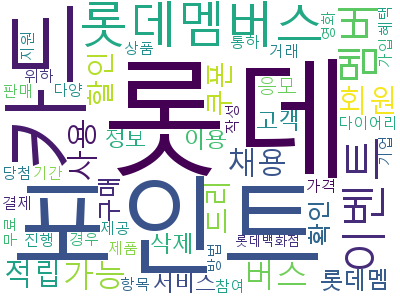

In [67]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

### LSA

In [68]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,
                  random_state=0)
svd.fit(tdm)
len(svd.components_)

print(np.shape(svd.components_))

terms = cv.get_feature_names()

def get_topics(components, feature_names, n=5) : 
    for idx, topic in enumerate(components) : # 각 토픽에 대한 주요 단어 n개 출력 
        print('Topic %d:' %(idx+1), [(feature_names[i], topic[i].round(5)) 
                    for i in topic.argsort()[:-n - 1 : -1]])
get_topics(svd.components_, terms)

(20, 5000)
Topic 1: [('롯데', 0.60097), ('업무', 0.21519), ('채용', 0.19321), ('지급', 0.18752), ('근무', 0.18618)]
Topic 2: [('업무', 0.28839), ('근무', 0.25251), ('지급', 0.2525), ('센터', 0.25105), ('롯데멤', 0.17275)]
Topic 3: [('포인트', 0.53021), ('카드', 0.29011), ('사용', 0.20175), ('적립', 0.16143), ('상품', 0.15676)]
Topic 4: [('채용', 0.64468), ('롯데그룹', 0.22876), ('인턴', 0.22069), ('롯데멤버스', 0.2153), ('자소서', 0.20175)]
Topic 5: [('포인트', 0.45852), ('채용', 0.16222), ('납부', 0.09088), ('전환', 0.07957), ('적립', 0.07758)]
Topic 6: [('카드', 0.7114), ('티머니', 0.28018), ('캐시비', 0.23865), ('발급', 0.22454), ('구하', 0.18006)]
Topic 7: [('다양', 0.19143), ('이벤트', 0.19043), ('면접', 0.18091), ('분석', 0.1627), ('경험', 0.13317)]
Topic 8: [('면접', 0.42314), ('합격', 0.16396), ('분석', 0.14617), ('기업', 0.13897), ('경험', 0.11917)]
Topic 9: [('상품', 0.31377), ('마일리지', 0.29695), ('구매', 0.27168), ('할인', 0.24231), ('면접', 0.22251)]
Topic 10: [('면접', 0.59498), ('유형', 0.16963), ('진행', 0.16474), ('계열사', 0.12256), ('이벤트', 0.12106)]
Topic 11: [('마일리지', 0.5782

### LDA

In [69]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)

def tokenizer(text):
    words = []
    stop_words = list(stop_word["token"])
    for word in token_re.findall(text):
        if word not in stop_words:
            words.append(word)
    return words

docs = []
for text in lotte["context"]:
    doc = tokenizer(text)
    docs.append(doc)
    
dic = Dictionary(docs)
dic.filter_extremes(no_below=10, no_above=0.9)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
    
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=5432)

In [70]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-11.231081117442958
-10.062781276705008
-9.595151519224363
-9.367892662229192
-9.239299089268703
-9.159293514109242


In [71]:
model.get_term_topics(dic.token2id['포인트'], 0.01)

[(15, 0.075463556),
 (24, 0.010622157),
 (26, 0.022934169),
 (40, 0.053972762),
 (41, 0.014005405),
 (60, 0.09280392),
 (61, 0.018586025),
 (67, 0.1686579),
 (72, 0.060585223),
 (80, 0.016646659),
 (97, 0.017906677)]

In [72]:
model.show_topic(60)

[('롯데포인트', 0.102548264),
 ('포인트', 0.09284533),
 ('이벤트', 0.09007542),
 ('할인', 0.08262427),
 ('기간', 0.07640574),
 ('1만', 0.075757466),
 ('다운로드', 0.075403124),
 ('롯데멤버스', 0.06998748),
 ('3천', 0.061841235),
 ('보기', 0.05414273)]

In [73]:
model.show_topic(10)

[('롯데멤버스', 0.044517964),
 ('분들은', 0.03768668),
 ('하네요', 0.034384742),
 ('보시면', 0.01950981),
 ('1만원', 0.018529344),
 ('롯데', 0.018305993),
 ('가셔서', 0.018198466),
 ('먼저', 0.014174363),
 ('롯데상품권', 0.013716764),
 ('아이들', 0.013444761)]

In [74]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dic, sort_topics=False)
pyLDAvis.display(p) 

C:\Users\USER\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


12 45 38 등등 - 주로 긍정적인 평가  
"다양한" 이라는 단어 등장. 롭스, 재휴사 등의 단어도 함께 나옴 

In [75]:
model.get_term_topics(dic.token2id['다양한'], 0.01)

[(7, 0.013413106),
 (11, 0.018392095),
 (21, 0.017864998),
 (29, 0.02129262),
 (35, 0.02059148),
 (44, 0.017939916),
 (52, 0.019955931),
 (91, 0.010531437),
 (95, 0.010275338)]

In [80]:
model.show_topic(29) # 다양한 이벤트가 매월 존재하는 ~ / 44도

[('롯데멤버스', 0.03275578),
 ('서비스', 0.026354954),
 ('매월', 0.025781902),
 ('이벤트', 0.02343362),
 ('다양한', 0.021302301),
 ('있는', 0.021267282),
 ('롯데멤버스의', 0.02086307),
 ('위한', 0.020245181),
 ('바로가기', 0.017470164),
 ('합니다', 0.012452939)]

In [86]:
model.show_topic(91) 

[('새로운', 0.03278079),
 ('것으로', 0.028315216),
 ('일을', 0.02689117),
 ('플랫폼', 0.026316587),
 ('지난해', 0.02536133),
 ('대비', 0.02209036),
 ('대한', 0.021621035),
 ('여행', 0.019514935),
 ('올해', 0.018637074),
 ('즐기는', 0.018439582)]

In [96]:
model.get_term_topics(dic.token2id['적립'], 0.01)

[(0, 0.01800613),
 (6, 0.016151607),
 (23, 0.0109249875),
 (39, 0.019277837),
 (86, 0.012771947),
 (89, 0.012679433)]

In [102]:
model.show_topic(86) 

[('좋네요', 0.12927702),
 ('이벤트도', 0.11552609),
 ('앞으로', 0.11065019),
 ('했는데요', 0.09974961),
 ('롯데멤버스', 0.07173543),
 ('좋은', 0.040076032),
 ('인도네시아', 0.020405432),
 ('사용이', 0.018786512),
 ('적립', 0.0129715735),
 ('택배로', 0.011886433)]

## title_context

In [29]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(lotte["title_context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


In [30]:
lotte_tf = word_count.sort_values("빈도",ascending = False)
lotte_tf = lotte_tf[lotte_tf.빈도 >= 10]
lotte_tf.head(10)

,단어,빈도,빈도가중치
1116,롯데,8284,142.527740
4555,포인트,5730,127.216004
1123,롯데멤버스,4193,100.039194
4151,카드,3605,99.813428
3266,이벤트,3301,104.854646
1315,멤버,3021,82.114855
1596,버스,2622,64.866573
10,가능,2414,44.537206
1902,사용,2372,53.159921
3977,채용,2238,50.076824


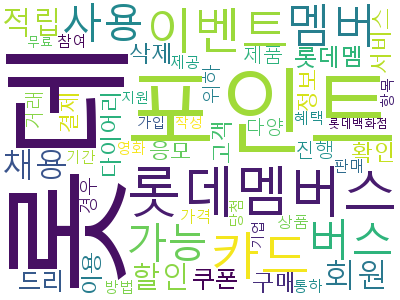

In [31]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

### LSA

In [32]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,
                  random_state=0)
svd.fit(tdm)
len(svd.components_)

print(np.shape(svd.components_))

terms = cv.get_feature_names()

def get_topics(components, feature_names, n=5) : 
    for idx, topic in enumerate(components) : # 각 토픽에 대한 주요 단어 n개 출력 
        print('Topic %d:' %(idx+1), [(feature_names[i], topic[i].round(5)) 
                    for i in topic.argsort()[:-n - 1 : -1]])
get_topics(svd.components_, terms)

(20, 5000)
Topic 1: [('롯데', 0.59962), ('업무', 0.21369), ('채용', 0.19757), ('지급', 0.18617), ('센터', 0.18597)]
Topic 2: [('업무', 0.28925), ('센터', 0.25395), ('지급', 0.2534), ('근무', 0.25245), ('롯데멤', 0.17401)]
Topic 3: [('포인트', 0.53724), ('카드', 0.28437), ('사용', 0.1982), ('적립', 0.16234), ('상품', 0.15047)]
Topic 4: [('채용', 0.6479), ('롯데그룹', 0.2257), ('인턴', 0.22313), ('롯데멤버스', 0.21698), ('자소서', 0.20125)]
Topic 5: [('포인트', 0.47987), ('채용', 0.15608), ('납부', 0.09099), ('전환', 0.08259), ('적립', 0.07761)]
Topic 6: [('카드', 0.71311), ('티머니', 0.27155), ('캐시비', 0.23911), ('발급', 0.21566), ('구하', 0.17918)]
Topic 7: [('이벤트', 0.22464), ('다양', 0.17956), ('롯데멤버스', 0.16641), ('면접', 0.15445), ('분석', 0.14122)]
Topic 8: [('면접', 0.4594), ('합격', 0.17438), ('분석', 0.15794), ('기업', 0.14676), ('경험', 0.12946)]
Topic 9: [('상품', 0.31957), ('마일리지', 0.30121), ('구매', 0.27816), ('할인', 0.2603), ('배송', 0.17322)]
Topic 10: [('면접', 0.6099), ('유형', 0.17256), ('진행', 0.16116), ('이벤트', 0.12479), ('계열사', 0.1208)]
Topic 11: [('마일리지', 0.59316

### LDA

In [33]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)

def tokenizer(text):
    words = []
    stop_words = list(stop_word["token"])
    for word in token_re.findall(text):
        if word not in stop_words:
            words.append(word)
    return words

docs = []
for text in lotte["title_context"]:
    doc = tokenizer(text)
    docs.append(doc)
    
dic = Dictionary(docs)
dic.filter_extremes(no_below=10, no_above=0.9)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
    
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=5432)

In [34]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-11.195757427821514
-10.032875950455255
-9.576032448778117
-9.35118921512054
-9.221202611158915
-9.139064517803648


In [35]:
model.get_term_topics(dic.token2id['포인트'], 0.01)

[(8, 0.027270878),
 (10, 0.013256391),
 (11, 0.011349361),
 (13, 0.02412519),
 (19, 0.083228536),
 (39, 0.026103007),
 (61, 0.29025948),
 (65, 0.011793508),
 (72, 0.072925135),
 (86, 0.011774981),
 (87, 0.014345514),
 (89, 0.03869783),
 (91, 0.014119013)]

In [37]:
model.show_topic(61)

[('포인트', 0.29030323),
 ('롯데백화점', 0.15064313),
 ('백화점', 0.11319256),
 ('명동', 0.1121508),
 ('가서', 0.107800044),
 ('영수증', 0.09376748),
 ('적립되는', 0.08333379),
 ('어쨌든', 0.0028157833),
 ('한다', 0.002796419),
 ('리워드', 0.0025440932)]

In [38]:
model.show_topic(19)

[('이벤트', 0.10698522),
 ('롯데포인트', 0.10096086),
 ('롯데멤버스', 0.08408428),
 ('포인트', 0.083261885),
 ('할인', 0.081824884),
 ('자세히', 0.058483064),
 ('결제로', 0.04946286),
 ('따뜻한', 0.04142579),
 ('있답니다', 0.023631576),
 ('1만', 0.02171732)]

In [39]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dic, sort_topics=False)
pyLDAvis.display(p) 

C:\Users\USER\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


# year별_wordcloud

In [87]:
lotte['year'] = lotte['date'].apply(lambda x : x[:4])

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


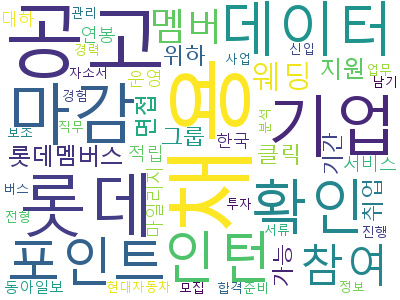

In [88]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(lotte.query('year == "2022"')["title_context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

lotte_tf = word_count.sort_values("빈도",ascending = False)
lotte_tf = lotte_tf[lotte_tf.빈도 >= 10]

from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

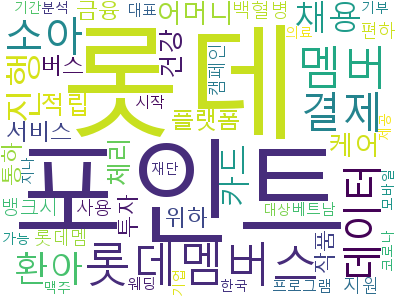

In [89]:
cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(lotte.query('year == "2021"')["title_context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

lotte_tf = word_count.sort_values("빈도",ascending = False)
lotte_tf = lotte_tf[lotte_tf.빈도 >= 10]

from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

In [92]:
lotte[lotte['title'].str.contains('환아')]['title_context']

290    [사회공헌 소식] 롯데멤버스, mom편한 포인트 맘케어 환아맘 건강검진 지원 보바스...
310    롯데멤버스 X 체리, 백혈병·소아암 환아맘 대상 힐링 프로그램 진행 간병으로 지친 ...
554    체리 블록체인 기부 플랫폼, 롯데멤버스, 롯데의료재단, 한국백혈병소아암협회와 소아암...
755    [공유] 롯데멤버스, 백혈병·소아암 환아 어머니 건강검진 지원 캠페인 진행 출처 :...
775    롯데멤버스와 함께하는 소아암 환아 어머니 후원 지난 10일 온라인으로 진행된 기부금...
Name: title_context, dtype: object

In [94]:
lotte[lotte['title'].str.contains('백혈병')]['title_context']

187    롯데멤버스-한국백혈병소아암협회, 맘편한 포인트 맘케어 캠페인 진행 한국백혈병소아암협...
288    롯데멤버스-한국백혈병소아암협회, 맘편한 포인트 맘케어 캠페인 진행 롯데멤버스 맘편한...
310    롯데멤버스 X 체리, 백혈병·소아암 환아맘 대상 힐링 프로그램 진행 간병으로 지친 ...
554    체리 블록체인 기부 플랫폼, 롯데멤버스, 롯데의료재단, 한국백혈병소아암협회와 소아암...
755    [공유] 롯데멤버스, 백혈병·소아암 환아 어머니 건강검진 지원 캠페인 진행 출처 :...
Name: title_context, dtype: object

In [95]:
lotte.iloc[187, :] #  ‘맘(mom)편한’ 캠페인

url                    https://blog.naver.com/yes1676/222686852341
type                                                    naver blog
title                         롯데멤버스-한국백혈병소아암협회, 맘편한 포인트 맘케어 캠페인 진행
date                                            2022. 3. 30. 12:17
context          한국백혈병소아암협회가 롯데멤버스대표이사 전형식와 롯데그룹 사회공헌 활동 맘mom편한...
title_context    롯데멤버스-한국백혈병소아암협회, 맘편한 포인트 맘케어 캠페인 진행 한국백혈병소아암협...
year                                                          2022
Name: 187, dtype: object

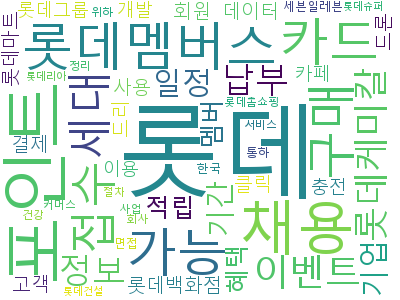

In [90]:
cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(lotte.query('year == "2020"')["title_context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

lotte_tf = word_count.sort_values("빈도",ascending = False)
lotte_tf = lotte_tf[lotte_tf.빈도 >= 10]

from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

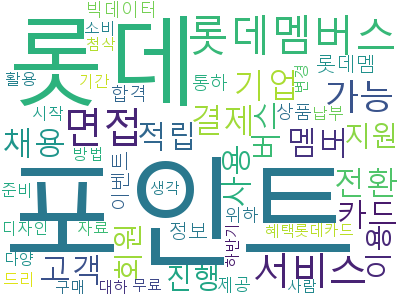

In [91]:
cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(lotte.query('year == "2019"')["title_context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

lotte_tf = word_count.sort_values("빈도",ascending = False)
lotte_tf = lotte_tf[lotte_tf.빈도 >= 10]

from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

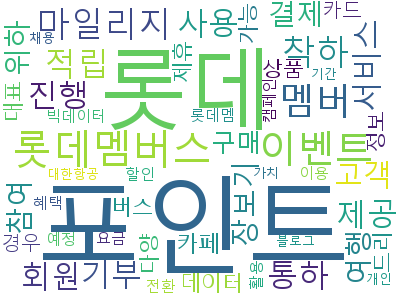

In [103]:
cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(lotte.query('year == "2018"')["title_context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

lotte_tf = word_count.sort_values("빈도",ascending = False)
lotte_tf = lotte_tf[lotte_tf.빈도 >= 10]

from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()